# **1. Loading & Cleaning Data**

In [138]:
import yfinance as yf

gold_ticker = yf.Ticker("GC=F")

df = gold_ticker.history(period="1mo", interval='5m')

df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

display(df.head(3))
display(df.shape)

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-08-19 16:00:00-04:00,2543.899902,2544.199951,2543.300049,2543.600098,0
2024-08-19 16:05:00-04:00,2543.600098,2544.000000,2543.199951,2543.199951,190
2024-08-19 16:10:00-04:00,2543.199951,2543.199951,2542.000000,2542.100098,299


(6052, 5)

# **Creating Constants needed**

In [139]:
WINDOW = 7

# RRR is 1 SL = TP = 1 STD
PNL = {
    'WIN': 1,
    'LOSS': -1
}

SIGNALS = {
    'BUY': 1,
    'SELL': -1
}

STD_FACTORS = {
    'ENTRY': 2.2,
    'SL': 0.1, # is calculated from entry
    'TP': 1 # is calculated from entry
}

# **2. Defining the Strategy (Mean Reversion)**

### We will create Columns needed

In [140]:
# Low
df['Mean_L'] = df['Low'].rolling(window=WINDOW).mean()
df['STD_L'] = df['Low'].rolling(window=WINDOW).std()
df['Z-Score_L'] = (df['Low'] - df['Mean_L']) / df['STD_L']

# High
df['Mean_H'] = df['High'].rolling(window=WINDOW).mean()
df['STD_H'] = df['High'].rolling(window=WINDOW).std()
df['Z-Score_H'] = (df['High'] - df['Mean_H']) / df['STD_H']

df.dropna(inplace=True)
df.reset_index(inplace=True)

display(df.head())

,Datetime,Open,High,Low,Close,Volume,Mean_L,STD_L,Z-Score_L,Mean_H,STD_H,Z-Score_H
0,2024-08-19 16:30:00-04:00,2542.800049,2543.000000,2542.399902,2542.699951,232,2542.571429,0.505680,-0.339199,2543.285714,0.575673,-0.496314
1,2024-08-19 16:35:00-04:00,2542.800049,2542.899902,2542.399902,2542.399902,63,2542.442836,0.390951,-0.109819,2543.099993,0.420312,-0.476053
2,2024-08-19 16:40:00-04:00,2542.199951,2542.300049,2541.800049,2541.899902,104,2542.242850,0.281972,-1.570373,2542.857143,0.281968,-1.975735
3,2024-08-19 16:45:00-04:00,2541.899902,2542.500000,2541.800049,2542.399902,105,2542.214286,0.318443,-1.300821,2542.757150,0.263653,-0.975333
4,2024-08-19 16:50:00-04:00,2542.399902,2543.000000,2542.300049,2542.800049,112,2542.242850,0.315447,0.181326,2542.785714,0.279435,0.766854


### Overview

<Axes: ylabel='Z-Score'>

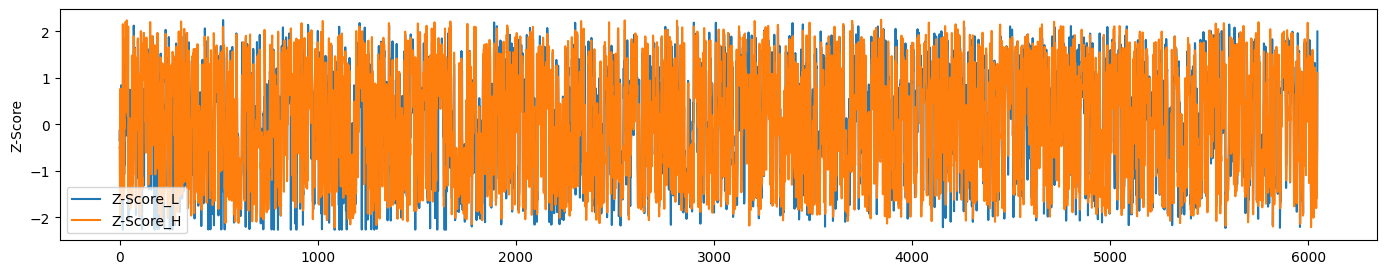

In [141]:
df[['Z-Score_L', 'Z-Score_H']].plot(kind='line', figsize=(17, 3), ylabel="Z-Score")

Z-Score_L
False    0.993384
True     0.006616
Name: proportion, dtype: float64

,Z-Score_L,Z-Score_H
max,2.244099,2.250915
min,-2.267684,-2.217209


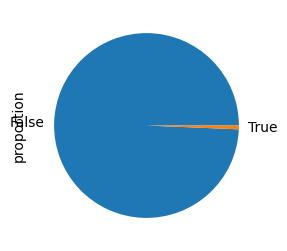

In [142]:
stats = (abs(df['Z-Score_L']) > STD_FACTORS['ENTRY']).value_counts(normalize=True)

display(stats)

stats.plot(kind='pie', figsize=(3, 3))

df[['Z-Score_L', 'Z-Score_H']].agg(['max', 'min'])

### Generate buy/sell signals

In [143]:
df['Signal'] = 0  # Default to hold/no position
df.loc[df['Z-Score_L'] < -STD_FACTORS['ENTRY'], 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[df['Z-Score_H'] > STD_FACTORS['ENTRY'], 'Signal']= SIGNALS['SELL']  # Sell signal

# **3. Implementing Stop Loss and Take Profit**

In [144]:
from helpers import Trade

# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
trade = Trade()

for i in range(0, len(df)):
    if not trade.on: 
        # Check if there's a BUY signal
        if df.loc[i, 'Signal'] == SIGNALS['BUY']:
            trade.on = True
            trade.entry = (df.loc[i, 'Mean_L']  - STD_FACTORS['ENTRY'] * df.loc[i, 'STD_L']) 
            trade.tp = trade.entry + STD_FACTORS['TP'] * df.loc[i, 'STD_L']
            trade.sl = trade.entry - STD_FACTORS['SL'] * df.loc[i, 'STD_L']
            df.loc[i, ['Position', 'Entry_Price']] = [SIGNALS['BUY'], trade.entry]
        # Check if there's a SELL signal
        if df.loc[i, 'Signal'] == SIGNALS['SELL']:
            trade.on = True
            trade.entry = (df.loc[i, 'Mean_H']  + STD_FACTORS['ENTRY'] * df.loc[i, 'STD_H'])
            trade.tp = trade.entry - STD_FACTORS['TP'] * df.loc[i, 'STD_H']
            trade.sl = trade.entry + STD_FACTORS['SL'] * df.loc[i, 'STD_H']
            df.loc[i, ['Position', 'Entry_Price']] = [SIGNALS['SELL'], trade.entry]
    else:
        # Track price movement for Stop Loss or Take Profit
        # In case of BUY
        if trade.is_buy:
            if df.loc[i, 'Low'] <= trade.sl:  # SL hit
                df.loc[i, 'Exit_Price'] = trade.sl
                df.loc[i, 'PnL'] = PNL['LOSS']
                trade.on = False  # Exit trade
            elif df.loc[i, 'High'] > trade.tp:  # TP hit
                df.loc[i, 'Exit_Price'] = trade.tp
                df.loc[i, 'PnL'] = PNL['WIN']
                trade.on = False  # Exit trade

        # In case of SELL
        if trade.is_sell:
            if df.loc[i, 'High'] >= trade.sl:  # SL hit
                df.loc[i, 'Exit_Price'] = trade.sl
                df.loc[i, 'PnL'] = PNL['LOSS']
                trade.on = False  # Exit trade
            elif df.loc[i, 'Low'] < trade.tp:  # TP hit
                df.loc[i, 'Exit_Price'] = trade.tp
                df.loc[i, 'PnL'] = PNL['WIN']
                trade.on = False  # Exit trade

In [145]:
df['PnL'].sum()

29.0

# **4. Backtesting & Overview**

In [146]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
win_rate = round(trades['PnL'].value_counts(normalize=True).loc[1], 3)

print(f"Total Trades: {total_trades}")
print(f"Total Profit/Loss: {total_pnl} RR")
print(f"Win rate: {win_rate * 100}%")

Total Trades: 53
Total Profit/Loss: 29.0 RR
Win rate: 77.4%


- **PnL**

<Axes: title={'center': 'PnL'}, xlabel='Datetime', ylabel='RR | %'>

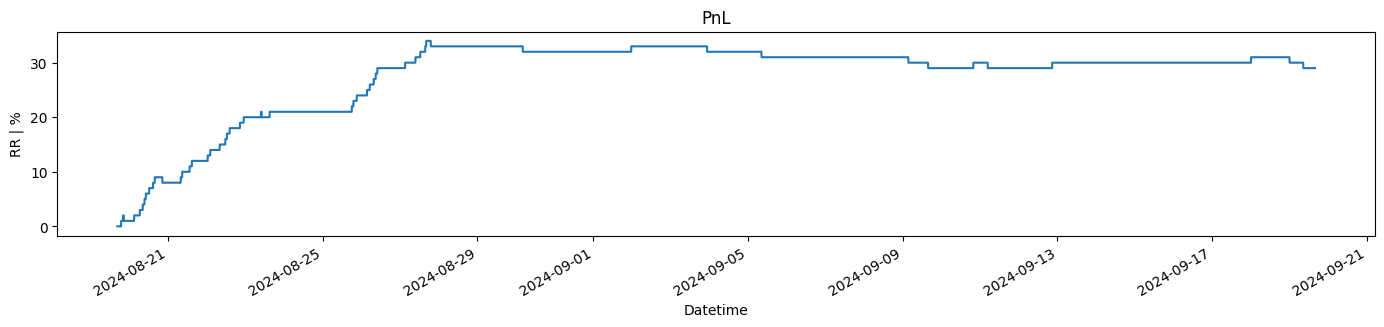

In [147]:
df.set_index('Datetime', inplace=True)

df['Cumulative_PnL'].plot(
    kind='line', 
    figsize=(17, 3), 
    title="PnL",
    ylabel="RR | %",
)

- **Drawdown** (not from Equity)

<Axes: title={'center': 'Drawdown'}, xlabel='Datetime', ylabel='RR | %'>

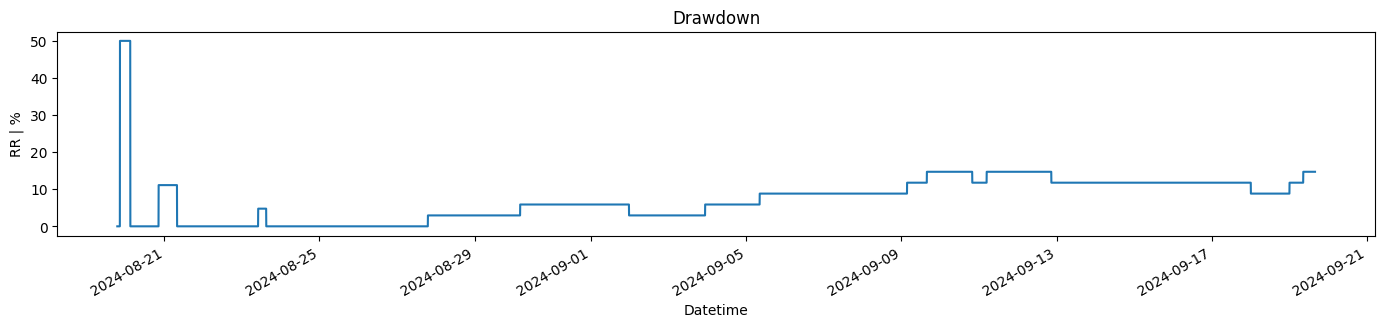

In [148]:
df['Peak'] = df['Cumulative_PnL'].cummax()

df['Drawdown'] = (df['Peak'] - df['Cumulative_PnL']) / df['Peak']

(df['Drawdown'] * 100).plot(
    kind='line', 
    figsize=(17, 3), 
    title="Drawdown",
    ylabel="RR | %",
)

In [149]:
print(f"Max drawdown is {round(100 * df['Drawdown'].max(), 2)} %")

Max drawdown is 50.0 %


# **5. A study on Drawdown**

In [150]:
import pandas as pd

# positions over 10% DD
dd_filter = (df['Drawdown'] > 0.1) & (df['Position'] != 0)

positions_during_DD = df.loc[dd_filter]['Position'].value_counts(normalize=True)

# [TODO] calculate the periode in which DD happened

PositionNature = {
    '1': 'Buy',
    '-1': 'Sell'
}

positions_during_DD.index = [PositionNature[str(x)] for x in positions_during_DD.index.to_list()]

<Axes: title={'center': 'Positions during Over 10% DD'}, ylabel='proportion'>

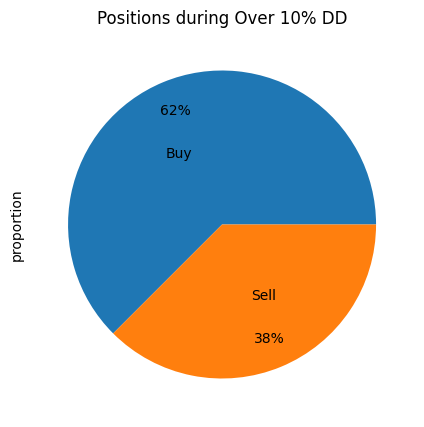

In [151]:
positions_during_DD.plot(
    kind='pie', 
    figsize=(5, 5), 
    title="Positions during Over 10% DD",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

<Axes: xlabel='Datetime'>

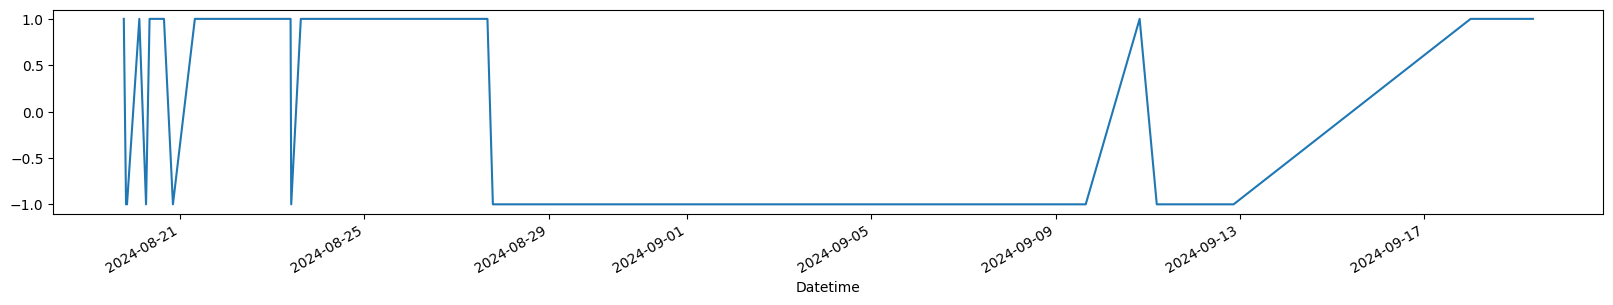

In [152]:
filtrty = df['Position'] != 0

df.loc[filtrty, 'Position'].plot(kind='line', figsize=(20, 3))

# [TODO] probability distribution

# **6. A study on positions nature**